In [1]:
import pandas as pd
import numpy as np

In [2]:
HEPG2_peaks = pd.read_csv("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/HEPG2/diff_acc_peaks.csv")
HEPG2_peaks = HEPG2_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
HEPG2_peaks['significant'] = np.where((HEPG2_peaks["padj"]<0.001) & (HEPG2_peaks["log2FoldChange"]>1), 'Significant', 'Not Significant')

In [3]:
GM12878_peaks = pd.read_csv("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/GM12878/diff_acc_peaks.csv")
GM12878_peaks = GM12878_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
GM12878_peaks['significant'] = np.where((GM12878_peaks["padj"]<0.001) & (GM12878_peaks["log2FoldChange"]>1), 'Significant', 'Not Significant')


In [4]:
K562_peaks = pd.read_csv("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/K562/diff_acc_peaks.csv")
K562_peaks = K562_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
K562_peaks['significant'] = np.where((K562_peaks["padj"]<0.001) & (K562_peaks["log2FoldChange"]>1), 'Significant', 'Not Significant')


In [5]:
H1ESC_peaks = pd.read_csv("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/H1ESC/diff_acc_peaks.csv")
H1ESC_peaks = H1ESC_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
H1ESC_peaks['significant'] = np.where((H1ESC_peaks["padj"]<0.001) & (H1ESC_peaks["log2FoldChange"]>1), 'Significant', 'Not Significant')


In [6]:
IMR90_peaks = pd.read_csv("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/IMR90/diff_acc_peaks.csv")
IMR90_peaks = IMR90_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
IMR90_peaks['significant'] = np.where((IMR90_peaks["padj"]<0.001) & (IMR90_peaks["log2FoldChange"]>1), 'Significant', 'Not Significant')


In [7]:
result = pd.concat([HEPG2_peaks,GM12878_peaks, K562_peaks, H1ESC_peaks, IMR90_peaks], axis=1, keys=['HEPG2', 'GM12878', "K562", "H1ESC", "IMR90"])

In [8]:
for df in [HEPG2_peaks,GM12878_peaks, K562_peaks, H1ESC_peaks, IMR90_peaks]:
    print(df[df["significant"]=="Significant"].shape[0])

34415
45478
37959
50361
52413


In [9]:
dfs = {
    'HEPG2': HEPG2_peaks,
    'GM12878': GM12878_peaks,
    'K562': K562_peaks,
    'H1ESC': H1ESC_peaks,
    'IMR90': IMR90_peaks
}

In [10]:
for key, df in dfs.items():
#     df = df.set_index('ID')
    df['significant'] = df['significant'].apply(lambda x: key if x == 'Significant' else None)
    dfs[key] = df[['significant']]  # We only keep the 'significant' column now

from functools import reduce
combined_df = reduce(lambda left, right: left.join(right, how='outer', rsuffix='_right'), dfs.values())
combined_df.columns = dfs.keys()  # Rename columns to DataFrame labels

combined_df['overlapping_dfs'] = combined_df.apply(lambda row: list(filter(None, row)), axis=1)

combined_df['overlap_count'] = combined_df['overlapping_dfs'].apply(len)

In [11]:
import pandas as pd
from upsetplot import UpSet
from collections import Counter
import matplotlib.pyplot as plt

# Convert the list of DataFrames into a Series of frozensets
set_series = combined_df['overlapping_dfs'].apply(frozenset)

# Count the frozensets
set_counts = Counter(set_series)

set_counts

Counter({frozenset(): 273029,
         frozenset({'K562'}): 37623,
         frozenset({'IMR90'}): 50783,
         frozenset({'GM12878'}): 45184,
         frozenset({'H1ESC'}): 49208,
         frozenset({'HEPG2'}): 33948,
         frozenset({'GM12878', 'IMR90'}): 158,
         frozenset({'H1ESC', 'IMR90'}): 843,
         frozenset({'IMR90', 'K562'}): 250,
         frozenset({'H1ESC', 'K562'}): 86,
         frozenset({'HEPG2', 'IMR90'}): 379,
         frozenset({'H1ESC', 'HEPG2'}): 88,
         frozenset({'GM12878', 'H1ESC'}): 136})

In [12]:
combined_df[combined_df["overlap_count"]>0][["overlapping_dfs", "overlap_count"]].to_csv("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/peaks_by_cell_label.csv", index=True, header=True)

In [13]:
cell_by_peaks = combined_df[combined_df["overlap_count"]>0][["overlapping_dfs", "overlap_count"]].copy(deep=True)

In [14]:
set_counts

Counter({frozenset(): 273029,
         frozenset({'K562'}): 37623,
         frozenset({'IMR90'}): 50783,
         frozenset({'GM12878'}): 45184,
         frozenset({'H1ESC'}): 49208,
         frozenset({'HEPG2'}): 33948,
         frozenset({'GM12878', 'IMR90'}): 158,
         frozenset({'H1ESC', 'IMR90'}): 843,
         frozenset({'IMR90', 'K562'}): 250,
         frozenset({'H1ESC', 'K562'}): 86,
         frozenset({'HEPG2', 'IMR90'}): 379,
         frozenset({'H1ESC', 'HEPG2'}): 88,
         frozenset({'GM12878', 'H1ESC'}): 136})

<Figure size 1440x360 with 0 Axes>

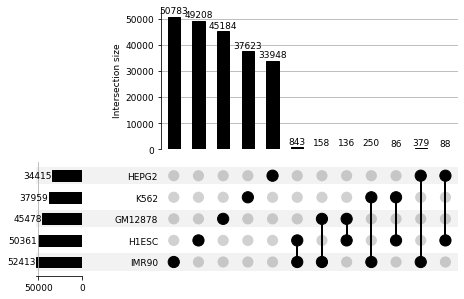

In [15]:
datasets = ['HEPG2', 'GM12878', 'K562', 'H1ESC', 'IMR90']

from itertools import product
all_combinations = list(product([False, True], repeat=len(datasets)))
multi_index = pd.MultiIndex.from_tuples(all_combinations, names=datasets)

# Create the Series
data_series = pd.Series(index=multi_index, dtype=int).fillna(0)  # Start with zero counts

# Map each frozenset to the appropriate index tuple and accumulate counts
for comb, count in set_counts.items():
    index_tuple = tuple(d in comb for d in datasets)
    data_series[index_tuple] += count  # Increment the count for each combination

# Ensure non-zero entries are present
# Plot using UpSet
plt.figure(figsize=(20, 5))
plt.tight_layout() 
plt.rcParams.update({'font.size': 9})  
upset = UpSet(data_series[data_series > 0], subset_size='sum', show_counts=True, max_subset_size="40%")
upset.plot()

plt.show()

In [16]:
for cell_type in datasets:
    print(cell_type)
    mask = cell_by_peaks['overlapping_dfs'].apply(lambda x: cell_type in x)
    df = cell_by_peaks[mask]
    df = df[df["overlap_count"]==1]
    print(df.shape)
    df.index.names = [cell_type + " Peaks"]
    pd.Series(df.index).to_csv(f'/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/{cell_type}/unique_peaks.csv', index=False)

HEPG2
(33948, 2)
GM12878
(45184, 2)
K562
(37623, 2)
H1ESC
(49208, 2)
IMR90
(50783, 2)


NameError: name 'combined_df' is not defined